# Classification Predict

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from matplotlib.colors import ListedColormap

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

### Data Pre-Processing

In [2]:
## Read the data
print ('Reading the data into Pandas DF...')
df = pd.read_csv(r'C:\Users\NL8409\Documents\Classification\train.csv', sep = ',')
test_df = pd.read_csv(r'C:\Users\NL8409\Documents\Classification\test.csv', sep = ',')

#posts - message
#type - sentiment
#tweetid

## Split train rows
print ('Seperating train data...')
all_df = []
for i, row in df.iterrows():
    for post in row['message'].split('|||'):
        all_df.append([row['sentiment'],row['tweetid'], post])
all_df = pd.DataFrame(all_df, columns=['sentiment', 'tweetid','message'])

## Split test rows
print ('Seperating test data...')
all_test_df = []
for i, row in test_df.iterrows():
    for post in row['message'].split('|||'):
        all_test_df.append([row['tweetid'],post])
all_test_df = pd.DataFrame(all_test_df, columns=['tweetid','message'])


# ## Remove train RT
# print ('Removing train RTs...')
# all_df['message'] = all_df['message'].str.replace('RT @[\w_]+: ', '')

# ## Remove test RT
# print ('Removing train RTs...')
# all_test_df['message'] = all_test_df['message'].str.replace('RT @[\w_]+: ', '')


## Remove train urls
print ('Removing train URLs...')
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_df['message'] = all_df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

## Remove test urls
print ('Removing test URLs...')
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
all_test_df['message'] = all_test_df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)


# Make train lower case
print ('Lowering train case...')
all_df['message'] = all_df['message'].str.lower()


# Make test lower case
print ('Lowering test case...')
all_test_df['message'] = all_test_df['message'].str.lower()


# Remove train punctuation
import string
print ('Cleaning train punctuation...')
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
all_df['message'] = all_df['message'].apply(remove_punctuation_numbers)


# Remove test punctuation
import string
print ('Cleaning test punctuation...')
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])
all_test_df['message'] = all_test_df['message'].apply(remove_punctuation_numbers)

Reading the data into Pandas DF...
Seperating train data...
Seperating test data...
Removing train URLs...
Removing test URLs...
Lowering train case...
Lowering test case...
Cleaning train punctuation...
Cleaning test punctuation...


In [3]:
print (all_df)

       sentiment  tweetid                                            message
0              1   625221  polyscimajor epa chief doesnt think carbon dio...
1              1   126103  its not like we lack evidence of anthropogenic...
2              2   698562  rt rawstory researchers say we have three year...
3              1   573736  todayinmaker wired   was a pivotal year in the...
4              1   466954  rt soynoviodetodas its  and a racist sexist cl...
5              1   425577  worth a read whether you do or dont believe in...
6              1   294933  rt thenation mike pence doesn’t believe in glo...
7              1   992717  rt makeandmendlife six big things we can all d...
8              1   664510  aceofspadeshq my yo nephew is inconsolable he ...
9              1   260471  rt paigetweedy no offense… but like… how do yo...
10             1   295793  rt stephenschlegel shes thinking about how she...
11             1   763719  i do hope people who are vocal about climate c...

In [4]:
# all_df = all_df.drop_duplicates()

In [5]:
# all_test_df = all_test_df.drop_duplicates()

In [6]:
all_df.count()

sentiment    15820
tweetid      15820
message      15820
dtype: int64

In [7]:
# all_test_df.count()
print(all_test_df)

       tweetid                                            message
0       169760  europe will now be looking to china to make su...
1        35326  combine this with the polling of staffers re c...
2       224985  the scary unimpeachable evidence that climate ...
3       476263  karoli morgfair osborneink dailykos \nputin go...
4       872928  rt fakewillmoore female orgasms cause global w...
5        75639  rt nycjim trump muzzles employees of several g...
6       211536  bmastenbrook yes wrote that in rd yr comp sci ...
7       569434  rt climatehawk indonesian farmers weather clim...
8       315368  rt guardian british scientists face a ‘huge hi...
9       591733  aid for agriculture  sustainable agriculture a...
10       91983       there is no climate change globalists urlweb
11       67249  biggest threat to our economy is climate chang...
12      143459  rt isnow hes ceo of a company that lied about ...
13      663535  rt vice venice could be swallowed by water wit...
14       2

In [8]:
all_df_plot = all_df.drop('tweetid', axis=1)
# X = mbti.drop('y', axis=1)
print (all_df_plot)

       sentiment                                            message
0              1  polyscimajor epa chief doesnt think carbon dio...
1              1  its not like we lack evidence of anthropogenic...
2              2  rt rawstory researchers say we have three year...
3              1  todayinmaker wired   was a pivotal year in the...
4              1  rt soynoviodetodas its  and a racist sexist cl...
5              1  worth a read whether you do or dont believe in...
6              1  rt thenation mike pence doesn’t believe in glo...
7              1  rt makeandmendlife six big things we can all d...
8              1  aceofspadeshq my yo nephew is inconsolable he ...
9              1  rt paigetweedy no offense… but like… how do yo...
10             1  rt stephenschlegel shes thinking about how she...
11             1  i do hope people who are vocal about climate c...
12             2  rt tveitdal we only have a  percent chance of ...
13             1  rt alifaith oh my god\n\ntrump

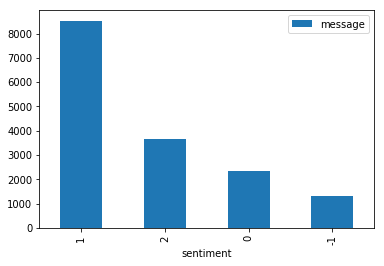

In [9]:
# Plot message by sentiment
sum_df = all_df_plot[['sentiment', 'message']].groupby('sentiment').count()
sum_df.sort_values('message', ascending=False).plot(kind='bar')
plt.show()

## Upsampling the data

In [10]:
believe = all_df[all_df['sentiment'] == 1]
no_belief = all_df[all_df['sentiment'] == -1]
neutral = all_df[all_df['sentiment'] == 0]
news = all_df[all_df['sentiment'] == 2]

#upsample minority
no_belief_upsampled = resample(no_belief,
                          replace=True, #sample with replacement
                          n_samples=len(believe), # match number in majority class
                          random_state=27) #reproducible results
neutral_upsampled = resample(neutral,
                          replace=True, #sample with replacement
                          n_samples=len(believe), # match number in majority class
                          random_state=27) #reproducible results
news_upsampled = resample(news,
                          replace=True, #sample with replacement
                          n_samples=len(believe), # match number in majority class
                          random_state=27) #reproducible results
# combine majority and upsampled inority
upsampled = pd.concat([believe, no_belief_upsampled, neutral_upsampled, news_upsampled])

In [11]:
upsampled_plot = upsampled.drop('tweetid', axis=1)

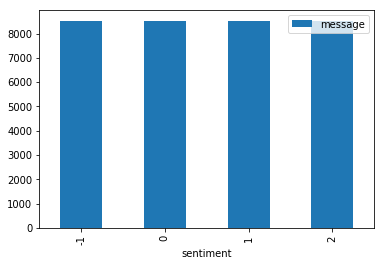

In [12]:
# Plot message by sentiment - Upsampled 
sum_df = upsampled_plot[['sentiment', 'message']].groupby('sentiment').count()
sum_df.sort_values('message', ascending=False).plot(kind='bar')
plt.show()

In [13]:
# X_resampled, y_resampled =SMOTE().fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))

In [14]:
X = upsampled['message']
X.shape

(34120,)

In [15]:
y = upsampled['sentiment']
y.shape

(34120,)

TfidF Vectorizer, removing all English stop words.

In [16]:
# Let's use the count vectorizer with its default hyperparameters
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2,stop_words='english')
X_vectorized = vectorizer.fit_transform(X)
X_vectorized.shape

(34120, 56070)

In [17]:
# sm = SMOTE(random_state=12, ratio = 1.0)
# x_SMOTE, y_SMOTE = sm.fit_sample(X, y) 

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y, test_size=0.3, random_state = 42) #stratify=y

In [19]:
np.mean(y_train)

0.49514319209512647

In [20]:
upsampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34120 entries, 0 to 15100
Data columns (total 3 columns):
sentiment    34120 non-null int64
tweetid      34120 non-null int64
message      34120 non-null object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [21]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15820 entries, 0 to 15819
Data columns (total 3 columns):
sentiment    15820 non-null int64
tweetid      15820 non-null int64
message      15820 non-null object
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


## Lets build some classification models!

In the next two cells, we will define the model names and call the model implementation classes. Note how some of the classifiers need input variables.  These are examples of **hyperparameters**. 

In [22]:
names = ['Logistic Regression', 
         #'Naive Bayes', 
         'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',  
         #'LDA', 'QDA',        
         'Decision Tree', 'Random Forest',  'AdaBoost']

In [23]:
classifiers = [
    LogisticRegression(multi_class='ovr'), 
    #GaussianNB(),
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier()
]

While this next cell is running, see if you can tell which algorithm takes the longest to train. Why do you think this is so?

In [24]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    print ('... predicting')
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_val)
    
    print ('... scoring')
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred, average='macro')
    recall    = metrics.recall_score(y_train, y_pred, average='macro')
    
    f1        = metrics.f1_score(y_train, y_pred,average='macro')    
    f1_test   = metrics.f1_score(y_val, y_pred_test,average='macro')    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])
    
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test','Train Time'])
results.set_index('Classifier', inplace= True)

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring


That's all done! Now let's take a look at the results.

In [25]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
RBF SVM,0.998158,0.998156,0.998164,0.998160,0.953759,147.799733
Logistic Regression,0.960978,0.961216,0.960997,0.960745,0.918694,0.670894
Nearest Neighbors,0.888293,0.888697,0.888334,0.888094,0.797709,0.004800
Decision Tree,0.637372,0.639432,0.638051,0.635108,0.612186,0.932994
AdaBoost,0.600109,0.615670,0.600512,0.595704,0.585715,11.192455
Linear SVM,0.582147,0.725582,0.580981,0.547102,0.523921,112.814684
Random Forest,0.279183,0.766053,0.275069,0.151776,0.138660,0.049322


This is way too many numbers to comprehend. Let's plot these values to see if we can make sense of them.

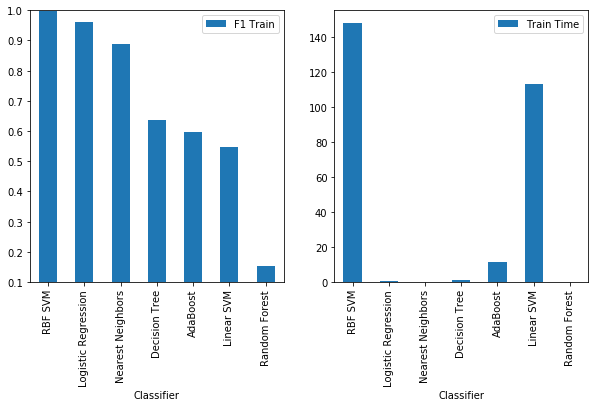

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Train'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.1,1.0])
results.plot(y='Train Time', kind='bar', ax=ax[1])

To better understand the performance of some of the models, lets view a few confusion matrices and classification reports of their results.

In [27]:
confusion['Logistic Regression']

array([[5892,   20,   21,   15],
       [  18, 5868,  118,   68],
       [  65,  180, 5390,  319],
       [  15,   20,   73, 5802]], dtype=int64)

In [28]:
confusion['RBF SVM']

array([[5940,    8,    0,    0],
       [   3, 6055,   11,    3],
       [   1,    1, 5940,   12],
       [   0,    1,    4, 5905]], dtype=int64)

In [29]:
print(class_report['RBF SVM'])

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00      5948
          0       1.00      1.00      1.00      6072
          1       1.00      1.00      1.00      5954
          2       1.00      1.00      1.00      5910

avg / total       1.00      1.00      1.00     23884



Can you use the above metrics to analyse the performance of the models? Which model do you think outperforms the rest?

In [30]:
from sklearn.model_selection import GridSearchCV

In [29]:
#K Nearest Neighbour Grid Search
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
param_grid = {'n_neighbors': ks}
grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='f1_macro')
grid_KNN.fit(X, y)

C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [108]:
#K Nearest Neighbour Results
grid_KNN.best_params_

{'n_neighbors': 10}

In [109]:
#SVM Grid Search
nfolds = 10

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {
    'C'     : Cs, 
    'gamma' : gammas
    }

grid_SVM = GridSearchCV(SVC(), param_grid, scoring='f1_macro', cv=nfolds)
grid_SVM.fit(X_train, y_train)

C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\NL8409\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

KeyboardInterrupt: 

In [ ]:
#SVM Results
grid_SVM.best_params_

In [ ]:
#Decision Tree Grid Search
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10],'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_DT = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, verbose=1, cv=3)
grid_DT.fit(X_train, y_train)


# ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
# param_grid = {'n_neighbors': ks}
# grid_KNN = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='f1_macro')
# grid_KNN.fit(X, y)

In [ ]:
#Decision Tree Results
grid_DT.best_params_

## Model Validation

But how do we know if these models are robust?  Model validation is the process of checking if our model produces reliable results. In order to make an informed choice, we need a way to *validate* that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls that you must avoid in order to do this effectively. 

### K Folds Cross Validation

In the rest of this train, we consider a common approach to validation called `k folds`. In its simplest form, k_folds fits a single model to a number of different versions of the test-train split and compares how volatile the results of the model are.

If you need a bit of a refresher on `k_fold` cross validation, or train test split in general, you can rewatch the following video from the Regression sprint [Regression | Train/Test Split](https://www.youtube.com/watch?v=T7PzngnKWq0&feature=youtu.be) or read through the K Folds Cross validation [Tutorial from Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/05/improve-model-performance-cross-validation-in-python-r/).

Cross validation can be easily implemented using `sklearn`. Let's do that for our Logistic Regression model and print out the performance of each fold.

In [31]:
model = models['Logistic Regression']
print(cross_val_score(model, X_vectorized, y))

[ 0.91490858  0.91065776  0.90969047]


In [32]:
model = models['RBF SVM']
print(cross_val_score(model, X_vectorized, y))

[ 0.94927918  0.94697503  0.94363349]


Let's now do the same for each of our models and print out the mean and standard deviation of each model's cross validation.

In [33]:
cv = []
for name, model in models.items():
    print ()
    print(name)
    scores = cross_val_score(model, X=X_vectorized, y=y, cv=10)
    print("Accuracy: {:0.2f} (+/- {:0.4f})".format(scores.mean(), scores.std()))
    cv.append([name, scores.mean(), scores.std() ])
    
cv = pd.DataFrame(cv, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cv.set_index('Model', inplace=True)


Logistic Regression
Accuracy: 0.93 (+/- 0.0051)

Nearest Neighbors
Accuracy: 0.84 (+/- 0.0039)

Linear SVM
Accuracy: 0.65 (+/- 0.0073)

RBF SVM
Accuracy: 0.97 (+/- 0.0022)

Decision Tree
Accuracy: 0.62 (+/- 0.0071)

Random Forest
Accuracy: 0.27 (+/- 0.0046)

AdaBoost
Accuracy: 0.59 (+/- 0.0112)


Now we can compare these results using a bar chart. Which model do you think is best suited to our dataset?

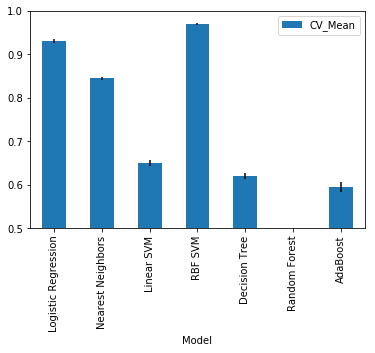

In [91]:
cv.plot(y='CV_Mean', yerr='CV_Std_Dev',kind='bar', ylim=[0.5, 1.0])

In [1]:
rbf = SVC(gamma=2, C=1)
rbf.fit(X_train, y_train)
rbf_pred = rbf.predict(X_val)

# lr = LogisticRegression(multi_class='ovr')
# lr.fit.fit(X_train, y_train)
# lr_pred = lr.predict(X_val)

NameError: name 'SVC' is not defined

In [48]:
metrics.f1_score(y_val, rbf_pred, average='macro')

#metrics.f1_score(y_val, lr_pred, average='macro')

0.48967507734770843

In [49]:
X_test = X = all_test_df['message']
test_vect = vectorizer.transform(X_test)

In [50]:
y_pred = rbf.predict(test_vect) 

#y_pred = lr.predict(test_vect) 

In [51]:
y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [52]:
all_test_df['sentiment'] = y_pred

In [53]:
daf=pd.DataFrame(y_pred, columns=['sentiment'])
daf.tail()

,sentiment
10541,1
10542,1
10543,1
10544,0
10545,1


In [54]:
output = pd.DataFrame({"tweetid":test_df['tweetid']})
submission = output.join(daf)
submission.to_csv("submission.csv", index=False)

In [55]:
submission.tail()

,tweetid,sentiment
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,0
10545,470892,1


In [57]:
# all_test_df[['tweetid', 'sentiment']].to_csv('TestSubmission.csv', Index=False)

In [26]:
# tweet = 'RT @username1: some tweet here, http://www.url.com, aaaaa @username2'
# tweet = re.sub('RT @[\w_]+: ', '', tweet)
# print(tweet)

some tweet here, http://www.url.com, aaaaa @username2
